In [1]:
import numpy as np
import pandas as pd
import io
import pickle
import os
import seaborn as sns
from matplotlib import pyplot as plt

import codicefiscale  # cool library to check fiscal code

## Dataset exploration: OpenCUP "TOTALE.csv"


The dataset is quite large, so we cache the parsed data after reading in a pickle file.

In [ ]:
dataset_path = 'TOTALE.csv'   # change your filepath here
cached_pickle_path = 'loadedPandasAscii.pickle' # change your filepath here

In [5]:
try:
    with open(cached_pickle_path, 'rb') as f:
        all_cup = pickle.load(f)
except IOError:
    all_cup = pd.read_csv(dataset_path, 
                      sep='|', quoting=3, encoding='ascii', 
                      error_bad_lines=False, warn_bad_lines=True)
    all_cup.to_pickle(cached_pickle_path)

In [6]:
goodFraction = 1-all_cup.sample(20000).isnull().mean(axis=0)
goodFraction.sort_values(ascending=False, inplace=True)
cup = all_cup.copy()
print(goodFraction.index[goodFraction < 0.3])
#cup = all_cup[goodFraction[goodFraction > 0.3].index].copy()

Index(['ALTRE_INFORMAZIONI', 'DATA_ULTIMA_MODIFICA_SSC', 'LINK_OPENCOESIONE',
       'RAGIONI_COLLEGAMENTO', 'CUP_MASTER', 'DATA_ULTIMA_MODIFICA_UTENTE',
       'DENOMINAZIONE_BENEFICIARIO', 'DENO_IMPRESA_STABILIMENTO_PREC',
       'LINK_SCUOLE_SICURE', 'CUP_IN_RELAZIONE', 'RUOLO_IN_RELAZIONE',
       'DESC_TIPO_RELAZIONE'],
      dtype='object')


In [7]:
# Anno delibera ha diversi typo. Estraiamoli.
bad_anno_delibera = cup.ANNO_DELIBERA[~cup.ANNO_DELIBERA.isin(
    ['DATO NON PRESENTE']+[str(x) for x in np.arange(1980,2021)])
                 ]
print(bad_anno_delibera, bad_anno_delibera.unique())

5418        NaN
62689       NaN
97169       NaN
97170       NaN
113838      NaN
156832     1198
165323      NaN
203199      NaN
250434     9999
251156      NaN
305766     2106
307480         
358986     9999
367951         
419523      NaN
435404     9999
436202      NaN
456293      NaN
507719      NaN
559054      NaN
559975         
580040      NaN
679712     0000
682565      NaN
692368     0000
702747     9999
767792      NaN
781843      NaN
789030     9999
868921         
           ... 
6134054     NaN
6144801     NaN
6146512    9999
6170762        
6175196    9999
6185478     NaN
6185479     NaN
6237579     NaN
6237580     NaN
6269810        
6274059    9999
6279755     NaN
6285964    9999
6289050     NaN
6297394    1198
6313769    9999
6337775    1015
6340991     NaN
6351632     NaN
6372548     NaN
6407345     NaN
6426712    9999
6495576     NaN
6495577     NaN
6503862    1198
6527908    9999
6547085     NaN
6555663    1198
6594266        
6603037    9999
Name: ANNO_DELIBERA, Len

In [5]:
# evaluate number of distinct field values
nUniques = cup.nunique()

In [6]:
cup.groupby(['STATO_PROGETTO'])['DATA_CHIUSURA_REVOCA'].count()

STATO_PROGETTO
ATTIVO         35
CHIUSO    2041601
Name: DATA_CHIUSURA_REVOCA, dtype: int64

In [7]:
# check CUP assignment dates
yy = pd.to_datetime(cup.DATA_GENERAZIONE_CUP.sample(20000), infer_datetime_format=True)
(yy > pd.to_datetime('2002')).mean()

1.0

In [8]:
# Check distribution in various countries
cup.groupby(
    ['STATO_PROGETTO', 'STATO'])['COSTO_PROGETTO'].sum().sort_values(ascending=False)

STATO_PROGETTO  STATO                            
ATTIVO          ITALIA                               4159751597991
CHIUSO          ITALIA                               1138711394700
ATTIVO          NON DEFINITO                              70300000
                FRANCIA                                   40377382
                GERMANIA                                  35657578
                SLOVENIA                                  32834143
                SPAGNA                                    31525358
                PAESI BASSI                               30381386
                REGNO UNITO                               28605913
                PORTOGALLO                                24053058
                AFGHANISTAN                               20181566
CHIUSO          POLONIA                                   18468278
                GERMANIA                                  17664006
                SPAGNA                                    16995528
            

In [9]:
print(cup.groupby('STATO_PROGETTO')['COSTO_PROGETTO'].sum())

STATO_PROGETTO
ATTIVO    4160145348300
CHIUSO    1138832450368
Name: COSTO_PROGETTO, dtype: int64


In [10]:
# compare project costs by their status
cup.groupby('STATO_PROGETTO').COSTO_PROGETTO.describe()

,count,mean,std,min,25%,50%,75%,max
STATO_PROGETTO,,,,,,,,
ATTIVO,4562274.0,911857.847271,3.743406e+07,1.0,8574.0,32000.0,153500.0,2.200000e+10
CHIUSO,2041658.0,557797.853690,1.168482e+07,1.0,7175.0,31799.0,123470.0,2.703291e+09


In [11]:
# add log of the cost as scale varies largely
cup['log_COSTO_PROGETTO'] = cup.COSTO_PROGETTO.apply(np.log)

In [12]:
cup['short_CATEGORIA_INTERVENTO'] = cup['CATEGORIA_INTERVENTO'].apply(lambda s: s[:80])

In [13]:
def plot_cost_by_column(column_name):
    nItems = cup[column_name].nunique()
    print('Found %i different categories' %nItems)
    print(cup.groupby(column_name).log_COSTO_PROGETTO.describe())
    # make some quick plots
    fig = plt.figure()
    fig.set_size_inches([16,10 *(1+nItems//8)])
    sns.violinplot(data=cup.sample(200000),
                   y=column_name, split=True,
                   x='log_COSTO_PROGETTO', hue='STATO_PROGETTO')
    plt.show()

Found 5 different categories
                                      count       mean       std  min  \
AREA_INTERVENTO                                                         
AMBIENTE ED ENERGIA                356311.0  12.075989  1.779545  0.0   
AREE PRODUTTIVE                   4585525.0  10.025202  2.023528  0.0   
IMMOBILI                           755912.0  11.448811  1.899145  0.0   
RICERCA, ITC, FORMAZIONE E ALTRO   513125.0  10.090790  2.549854  0.0   
TRASPORTI                          393059.0  12.151910  1.922769  0.0   

                                        25%        50%        75%        max  
AREA_INTERVENTO                                                               
AMBIENTE ED ENERGIA               11.002100  12.072541  13.133760  20.875419  
AREE PRODUTTIVE                    8.699515   9.961756  11.366164  22.616077  
IMMOBILI                          10.239960  11.512925  12.697715  21.862599  
RICERCA, ITC, FORMAZIONE E ALTRO   8.132706  10.016816  12.13176

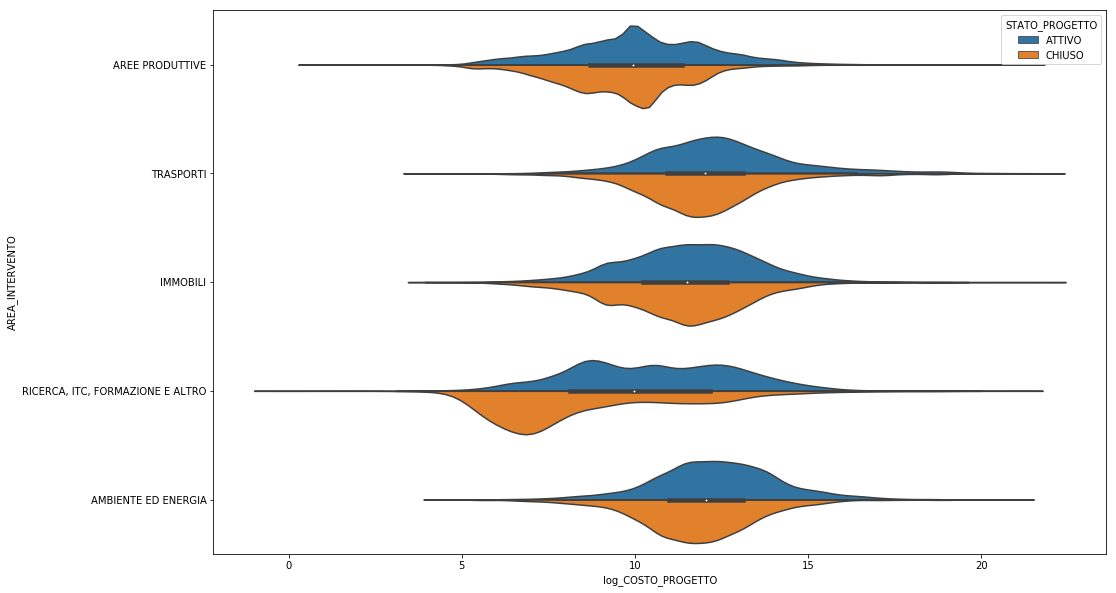

In [14]:
plot_cost_by_column('AREA_INTERVENTO')

In the above, we note that "RICERCA, ITC, FORMAZIONE E ALTRO" has a wide difference between closed and open projects. This could be investigated including project timing in the analysis.

Found 11 different categories
                                                        count       mean  \
SETTORE_INTERVENTO                                                         
INFRASTRUTTURE AMBIENTALI E RISORSE IDRICHE          285298.0  12.188421   
INFRASTRUTTURE DEL SETTORE ENERGETICO                 71013.0  11.624290   
INFRASTRUTTURE DI TRASPORTO                          393059.0  12.151910   
INFRASTRUTTURE PER L'ATTREZZATURA DI AREE PRODU...    59395.0  11.202128   
INFRASTRUTTURE PER TELECOMUNICAZIONI E TECNOLOG...    27691.0  10.614805   
INFRASTRUTTURE SOCIALI                               755912.0  11.448811   
ISTRUZIONE, FORMAZIONE E SOSTEGNI PER IL MERCAT...  1257330.0   9.561937   
OPERE, IMPIANTI ED ATTREZZATURE PER ATTIVITA' P...  2404588.0  10.505927   
RICERCA SVILUPPO TECNOLOGICO ED INNOVAZIONE          209047.0  11.890703   
SERVIZI ALLE IMPRESE                                1128779.0   9.105653   
SERVIZI PER LA P.A. E PER LA COLLETTIVITA'            1182

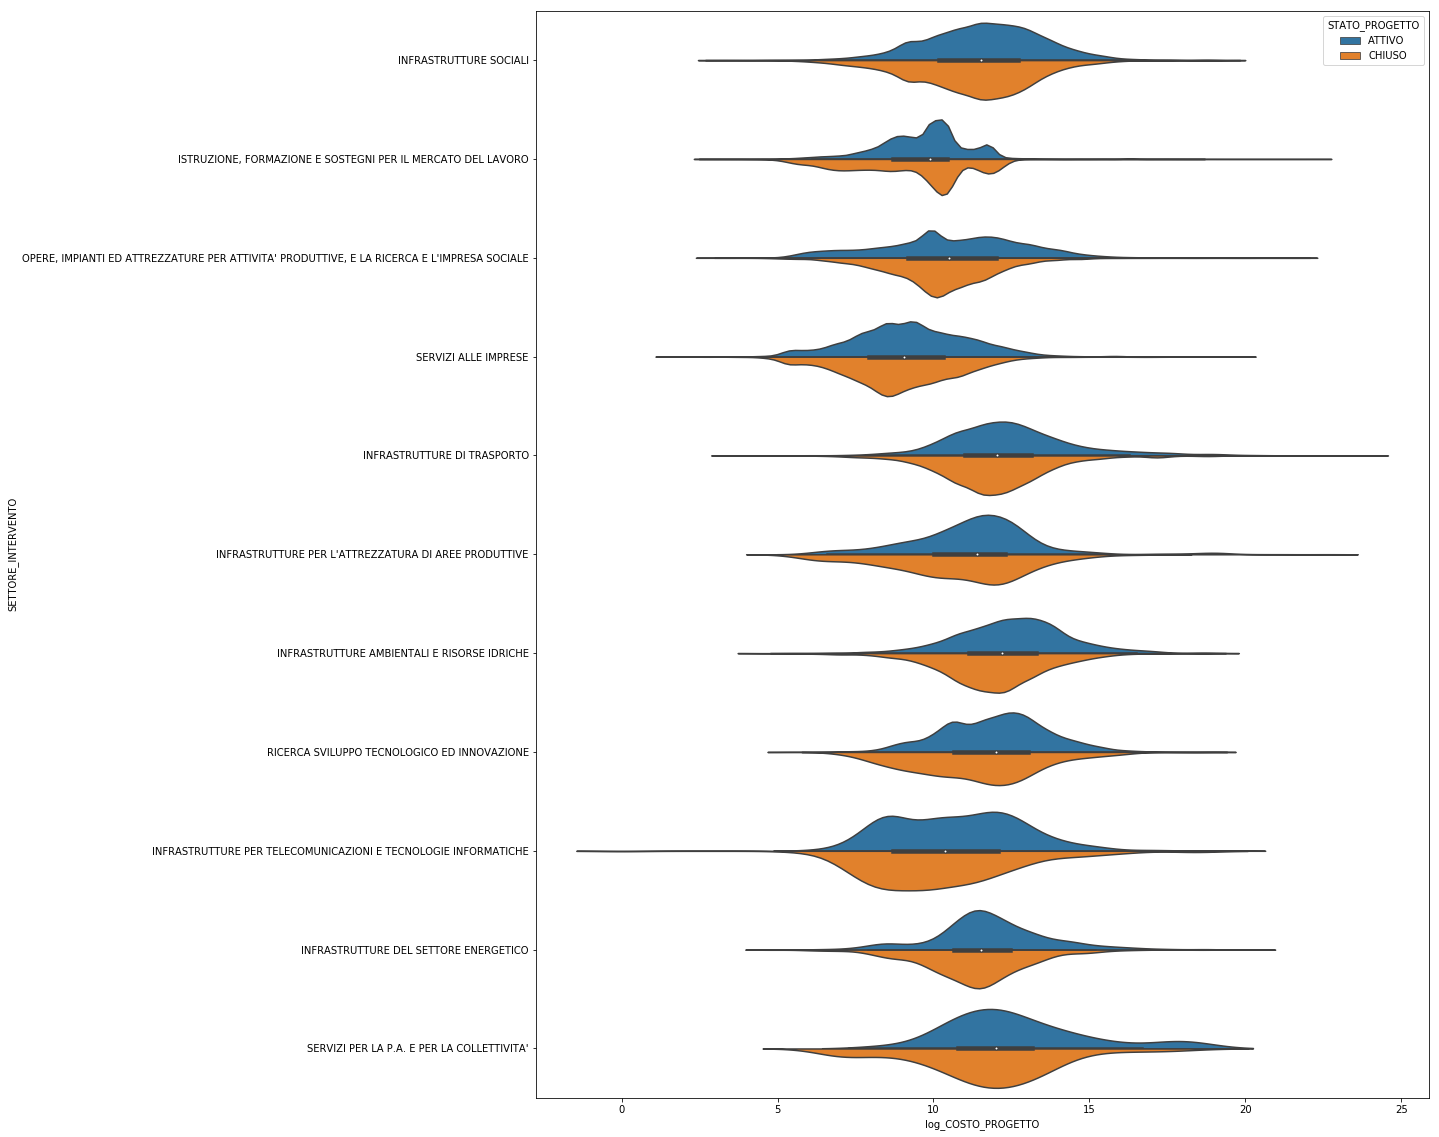

In [15]:
plot_cost_by_column('SETTORE_INTERVENTO')

In [16]:
chiusi = cup[~cup.DATA_CHIUSURA_REVOCA.isnull()].copy()

In [17]:
chiusi['year_CHIUSURA'] = '20'+chiusi.DATA_CHIUSURA_REVOCA.apply(lambda s: s[-2:])

In [18]:
# Show projects that are closed before they are "decided"... Sic.
chiusi[chiusi.ANNO_DECISIONE > chiusi['year_CHIUSURA'].astype(int)]

,CUP,DESCRIZIONE_SINTETICA_CUP,ANNO_DECISIONE,STATO_PROGETTO,COSTO_PROGETTO,FINANZIAMENTO_PROGETTO,CODICE_STATO,STATO,CODICE_AREA_GEOGRAFICA,AREA_GEOGRAFICA,...,GRUPPO_ATECO,COD_CLASSE_ATECO,CLASSE_ATECO,COD_CATEGORIA_ATECO,CATEGORIA_ATECO,COD_SOTTOCATEG_ATECO,SOTTOCATEGORIA_ATECO,log_COSTO_PROGETTO,short_CATEGORIA_INTERVENTO,year_CHIUSURA
55939,D21B07000040001,SOPPRESSIONE PASSAGGI A LIVELLO: VIABILITA' AL...,2007,CHIUSO,516457,516457,5,ITALIA,NO,NORD-OVEST,...,AMMINISTRAZIONE PUBBLICA: AMMINISTRAZIONE GENE...,84.11,Attivita generali di amministrazione pubblica,84.11.2,Attivita di pianificazione generale e servizi...,84.11.20,Attivita di pianificazione generale e servizi...,13.154747,"STRADE REGIONALI, PROVINCIALI E COMUNALI",2006
84400,D89D16002340002,C.I. EL IMPIANTI SRL*L.R. 18/05 REGIONE FVG - ...,2017,CHIUSO,4500,4500,5,ITALIA,NE,NORD-EST,...,"INSTALLAZIONE DI IMPIANTI ELETTRICI, IDRAULICI...",43.21,Installazione di impianti elettrici,43.21.0,Installazione di impianti elettrici ed elettro...,43.21.03,Installazione impianti di illuminazione strada...,8.411833,ALTRI SOSTEGNI PER IL MERCATO DEL LAVORO,2016
195022,D69G16000730002,PUNTOFIT DI CESCHIUTTI MICHELA*L.R. 18/05 REGI...,2017,CHIUSO,1450,1450,5,ITALIA,NE,NORD-EST,...,ATTIVITA' SPORTIVE,93.11,Gestione di impianti sportivi,93.11.2,Gestione di piscine,93.11.20,Gestione di piscine,7.279319,ALTRI CONTRIBUTI ALL'OCCUPAZIONE,2016
346499,D29G16002130002,A.ED.F SRL*L.R. 18/05 REGIONE FVG - LAVORATORE...,2017,CHIUSO,1000,1000,5,ITALIA,NE,NORD-EST,...,RISTORANTI E ATTIVITA' DI RISTORAZIONE MOBILE,56.10,Ristoranti e attivita di ristorazione mobile,56.10.4,Ristorazione ambulante e gelaterie ambulanti,56.10.42,Ristorazione ambulante,6.907755,ALTRI CONTRIBUTI ALL'OCCUPAZIONE,2016
359312,D59G16001440002,"COGOI ROCCO - ""EDICOLA CENTRO""*L.R. 18/05 REGI...",2017,CHIUSO,980,980,5,ITALIA,NE,NORD-EST,...,COMMERCIO AL DETTAGLIO DI ARTICOLI CULTURALI E...,47.62,Commercio al dettaglio di giornali e articoli ...,47.62.1,"Commercio al dettaglio di giornali, riviste e ...",47.62.10,"Commercio al dettaglio di giornali, riviste e ...",6.887553,ALTRI CONTRIBUTI ALL'OCCUPAZIONE,2016
751879,D89D16002340002,C.I. EL IMPIANTI SRL*L.R. 18/05 REGIONE FVG - ...,2017,CHIUSO,4500,4500,5,ITALIA,NE,NORD-EST,...,"INSTALLAZIONE DI IMPIANTI ELETTRICI, IDRAULICI...",43.21,Installazione di impianti elettrici,43.21.0,Installazione di impianti elettrici ed elettro...,43.21.01,Installazione di impianti elettrici in edifici...,8.411833,ALTRI SOSTEGNI PER IL MERCATO DEL LAVORO,2016
764088,D25B07000000002,RESTAURO E RISANAMENTO CONSERVATIVO EX SCUOLA ...,2007,CHIUSO,200000,200000,5,ITALIA,NO,NORD-OVEST,...,AMMINISTRAZIONE PUBBLICA: AMMINISTRAZIONE GENE...,84.11,Attivita generali di amministrazione pubblica,84.11.1,Attivita degli organi legislativi ed esecutiv...,84.11.10,Attivita degli organi legislativi ed esecutiv...,12.206073,ASILI NIDO,2006
800359,D21B07000050002,PISTA CICLABILE (ZONA CIMITERO - LOCALITA' BAR...,2007,CHIUSO,258228,258228,5,ITALIA,NO,NORD-OVEST,...,AMMINISTRAZIONE PUBBLICA: AMMINISTRAZIONE GENE...,84.11,Attivita generali di amministrazione pubblica,84.11.1,Attivita degli organi legislativi ed esecutiv...,84.11.10,Attivita degli organi legislativi ed esecutiv...,12.461598,PISTE CICLABILI,2006
981379,F78F07000060001,MANUTENZIONE ORDINARIA DIPINTI GALLERIA NAZIONALE,2007,CHIUSO,60000,60000,5,ITALIA,NE,NORD-EST,...,AMMINISTRAZIONE PUBBLICA: AMMINISTRAZIONE GENE...,84.11,Attivita generali di amministrazione pubblica,84.11.1,Attivita degli organi legislativi ed esecutiv...,84.11.10,Attivita degli organi legislativi ed esecutiv...,11.002100,RESTAURO E RIQUALIFICAZIONE DI BENI CULTURALI,2006
1197611,D49D16001890002,MF COSTRUZIONI DI FANTINI MASSIMO & C. SNC*L.R...,2017,CHIUSO,2500,2500,5,ITALIA,NE,NORD-EST,...,COSTRUZIONE DI EDIFICI RESIDENZIALI E NON RESI...,41.20,Costruzione di edifici residenziali e non resi...,41.20.0,Costruzione di edifici residenziali e non resi...,41.20.00,Costruzione di edifici res

In [19]:
chiusi = chiusi[chiusi.ANNO_DECISIONE <= chiusi['year_CHIUSURA'].astype(int)]  # cleanup

In [20]:
chiusi['ANNI_RICHIESTI'] = chiusi['year_CHIUSURA'].astype(int) - chiusi.ANNO_DECISIONE

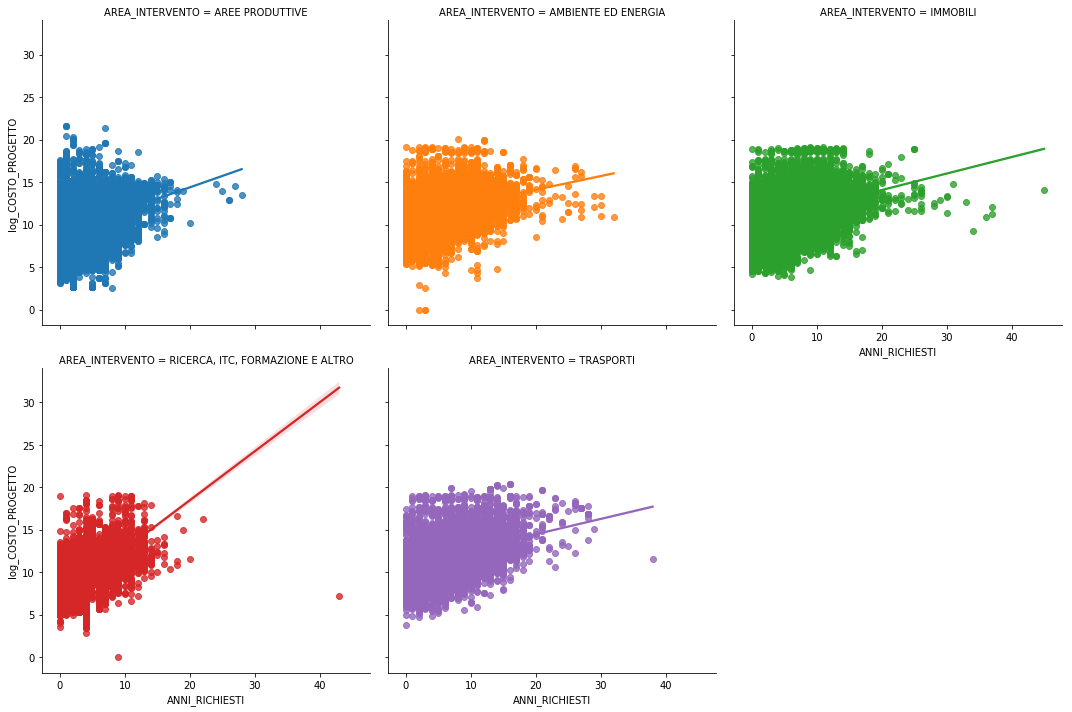

In [21]:
#sns.regplot(data=chiusi.sample(3000), x='ANNI_RICHIESTI', y='log_COSTO_PROGETTO', hue='SETTORE_INTERVENTO')
axSplit = sns.lmplot( x='ANNI_RICHIESTI', y='log_COSTO_PROGETTO', data=chiusi.sample(300000), 
                        truncate=True, hue='AREA_INTERVENTO', col='AREA_INTERVENTO', col_wrap=3)

In [22]:
# parsing pIva / COD FISCALE
cup_std = cup.copy()

def standardize_titolare(col):
    n_fixed = 0
    for i_row, row_values in enumerate(col):
        assert isinstance(row_values, str), 'Please provide strings as input values'
        # detect NaNs
        if row_values in ('NaN', 'nan'):
            col[i_row] = 'NaN'
        # check if a letter is present, in which case it should be a valid Fiscal Code:
        elif any([l.isalpha() for l in row_values]):
            if not codicefiscale.isvalid(row_values):
                print('Invalid codice fiscale with letters %s' % row_values)
        else:    
            # it should be a partita iva, convert to int and pad to 11 chars
            col[i_row] = str(int(float(row_values))).rjust(11, '0')
            if col[i_row] != row_values:
                n_fixed += 1
    print('Fixed %i lines' % n_fixed)
    return col

In [33]:
cup_std.PIVA_CODFISCALE_SOG_TITOLARE = \
    standardize_titolare(cup_std.PIVA_CODFISCALE_SOG_TITOLARE.values.astype(str))

Invalid codice fiscale with letters BCCFLC59019A285L
Fixed 0 lines


In [24]:
(cup.PIVA_CODFISCALE_SOG_TITOLARE.nunique(), cup_std.PIVA_CODFISCALE_SOG_TITOLARE.nunique())

(29848, 16261)

In [25]:
grpby_by_titolare = cup_std.groupby(['PIVA_CODFISCALE_SOG_TITOLARE', 'STATO_PROGETTO'])
data_by_titolare = grpby_by_titolare.agg({'CUP': 'count', 'COSTO_PROGETTO': 'sum'})
data_by_titolare.sort_values('COSTO_PROGETTO', ascending=False, inplace=True)
data_by_titolare

,,COSTO_PROGETTO,CUP
PIVA_CODFISCALE_SOG_TITOLARE,STATO_PROGETTO,,
80230390587,ATTIVO,751147527555,1067662
01585570581,ATTIVO,637433591900,7466
80208450587,ATTIVO,319606778560,25694
80014930327,ATTIVO,247266563255,90429
80011990639,ATTIVO,209519781661,84064
80012000826,ATTIVO,150956882876,321854
80007580279,ATTIVO,139155293142,76090
02205340793,ATTIVO,84814118747,64147
01585570581,CHIUSO,78606861816,3310


The most influential owners have a lot of different projects and account for a very large proportion of the total cost. The top 10 alone have over 2,5MM budget!

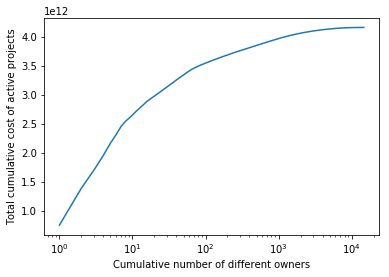

In [26]:
# Plot cumulative number of different owners of active projects against cumulative cost
plt.semilogx(np.arange(data_by_titolare.xs('ATTIVO', level=1).shape[0])+1,
         data_by_titolare.xs('ATTIVO', level=1).COSTO_PROGETTO.cumsum())
plt.xlabel('Cumulative number of different owners')
plt.ylabel('Total cumulative cost of active projects')
plt.show()

### Plot the ratio between project cost and number of projects for the different subject areas

In [27]:
grpby_by_area_titolare = cup_std[cup_std['STATO_PROGETTO']=='ATTIVO'].groupby(['AREA_SOGGETTO','PIVA_CODFISCALE_SOG_TITOLARE'])
data_by_area_titolare = grpby_by_area_titolare.agg({'CUP': 'count', 'COSTO_PROGETTO': 'sum'})
data_by_area_titolare.sort_values('COSTO_PROGETTO', ascending=False, inplace=True)

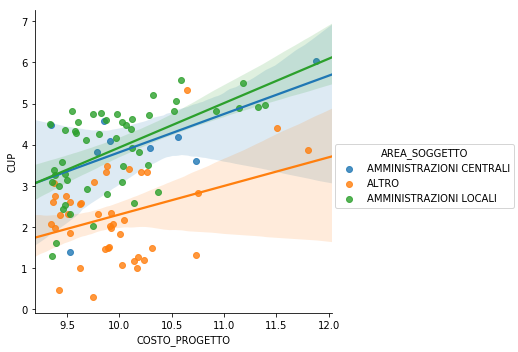

In [28]:
log_data_by_area_titolare = data_by_area_titolare.apply(np.log10).reset_index(level=0)
# plot top 100 (high total cost per single owner)
sns.lmplot(data=log_data_by_area_titolare.head(100), y='CUP', x='COSTO_PROGETTO', hue= 'AREA_SOGGETTO')
plt.show()

### Export cleaned codice fiscale/ P.iva for joins with other data

In [65]:
cup_std[cup_std.PIVA_CODFISCALE_SOG_TITOLARE == '02196020263'].AREA_SOGGETTO

33063      AMMINISTRAZIONI LOCALI
384421     AMMINISTRAZIONI LOCALI
490003     AMMINISTRAZIONI LOCALI
989333     AMMINISTRAZIONI LOCALI
2345157    AMMINISTRAZIONI LOCALI
2937513    AMMINISTRAZIONI LOCALI
3158088    AMMINISTRAZIONI LOCALI
3266373    AMMINISTRAZIONI LOCALI
3385548    AMMINISTRAZIONI LOCALI
3475820    AMMINISTRAZIONI LOCALI
3997686    AMMINISTRAZIONI LOCALI
4051181    AMMINISTRAZIONI LOCALI
4146832    AMMINISTRAZIONI LOCALI
4214396    AMMINISTRAZIONI LOCALI
4255107    AMMINISTRAZIONI LOCALI
4679463    AMMINISTRAZIONI LOCALI
4720826    AMMINISTRAZIONI LOCALI
5569954    AMMINISTRAZIONI LOCALI
5893128    AMMINISTRAZIONI LOCALI
6048380    AMMINISTRAZIONI LOCALI
6376701    AMMINISTRAZIONI LOCALI
6463436    AMMINISTRAZIONI LOCALI
Name: AREA_SOGGETTO, dtype: object

In [66]:
export_data = cup_std.groupby(['AREA_SOGGETTO','PIVA_CODFISCALE_SOG_TITOLARE', 'STATO_PROGETTO']).agg(
    {'CUP': 'count', 'COSTO_PROGETTO': 'sum'})
export_data.rename({'COSTO_PROGETTO': 'totale_costi_progetti', 
                    'PIVA_CODFISCALE_SOG_TITOLARE': 'codice_fiscale_titolare_opencup',
                    'AREA_SOGGETTO': 'area_titolare_opencup',
                    'CUP':'numero_totale_cup_titolare'})
export_data.to_csv('sintesi_partite_iva_opencup.csv', sep=';')

In [40]:
pd.read_csv('sintesi_partite_iva_opencup.csv', sep=';')

,AREA_SOGGETTO,PIVA_CODFISCALE_SOG_TITOLARE,COSTO_PROGETTO,CUP
0,AMMINISTRAZIONI CENTRALI,80230390587,751147527555,1067662
1,ALTRO,01585570581,637433591900,7466
2,ALTRO,80208450587,319606778560,25694
3,AMMINISTRAZIONI LOCALI,80014930327,247266563255,90429
4,AMMINISTRAZIONI LOCALI,80011990639,209519781661,84064
5,AMMINISTRAZIONI LOCALI,80012000826,150956882876,321854
6,AMMINISTRAZIONI LOCALI,80007580279,139155293142,76090
7,AMMINISTRAZIONI LOCALI,02205340793,84814118747,64147
8,ALTRO,07516911000,55924207325,682
9,AMMINISTRAZIONI CENTRALI,80188230587,53557949338,4107


In [30]:
ratios = log_data_by_area_titolare.CUP/log_data_by_area_titolare.COSTO_PROGETTO
ratios.name = 'Fragmentation'

In [31]:
info = cup_std[['PIVA_CODFISCALE_SOG_TITOLARE',
         'SOGGETTO_TITOLARE']].drop_duplicates().set_index('PIVA_CODFISCALE_SOG_TITOLARE')

In [32]:
ratios.to_frame().join(info).sort_values('Fragmentation', ascending=False)

,Fragmentation,SOGGETTO_TITOLARE
PIVA_CODFISCALE_SOG_TITOLARE,,
80005290160,0.540058,CAMERA DI COMMERCIO INDUSTRIA ARTIGIANATO E AG...
97278470584,0.536691,FONDIMPRESA
80000090805,0.525806,CAMERA DI COMMERCIO INDUSTRIA ARTIGIANATO E AG...
80062590379,0.525323,REGIONE EMILIA ROMAGNA
80005410099,0.518420,CAMERA DI COMMERCIO INDUSTRIA ARTIGIANATO E AG...
03254220159,0.512900,UNIONE REGIONALE DELLE CAMERE DI COMMERCIO IND...
80000110041,0.512230,CAMERA DI COMMERCIO INDUSTRIA ARTIGIANATO E AG...
80001090572,0.511265,CAMERA DI COMMERCIO INDUSTRIA ARTIGIANATO E AG...
80230390587,0.507627,MINISTERO DELLO SVILUPPO ECONOMICO


In [60]:
all_codes = cup_std.CODICE_LOCALE_PROGETTO.unique()

In [61]:
pd.Series(all_codes).to_csv('codici_progetto_interni_opencup.csv')